In [1]:
import os
from sys import platform

import pyNetLogo

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from collections import Counter

In [2]:
if platform == "linux":
    os.environ["NetLogo"] = "/home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1"
    
for key in os.environ:
    if key.lower() == "netlogo":
        print(f"{key} -> {os.environ[key]}")

NetLogo -> /home/paulo/Desktop/TFC/NetLogo-6.2.1-64/NetLogo 6.2.1


In [3]:
if platform == "linux":
    ku_model_path = os.path.abspath(os.getcwd()) + "/files/knowledge_units_with_board.nlogo"    
elif platform == "win32":
    ku_model_path = os.path.abspath(os.getcwd()) + "\\files\\knowledge_units_with_board.nlogo"

netlogo = pyNetLogo.NetLogoLink(
    # ADD ( NetLogo : path )  AS AN ENVIRONMENT VARIABLE !!!
    gui=False,
    netlogo_home = os.environ['NetLogo'],
    netlogo_version="6.2",
)

netlogo.load_model(ku_model_path)

keys = [
    "number_of_agents",
    "ku_number",
    "ku_len",
    "c_threshold",
    "probability_exploit",
]
values = [6, 9, 8, 0.5, 0.5]

experiment = {k: v for k, v in zip(keys, values)}

# Set the input parameters
for key, value in zip(keys, values):
    if key == "random-seed":
        # The NetLogo random seed requires a different syntax
        netlogo.command("random-seed {}".format(value))
    else:
        # Otherwise, assume the input parameters are global variables
        netlogo.command(f"set {key} {value}")

netlogo.command("setup")

In [4]:
def nd_array_to_compats(ndarr):
    compats = []
    curr_compat = []

    # iterate current and next element
    for curr, _next in zip(ndarr, ndarr[1:]):
        curr_compat.append(curr)

        # if next element is lower than current, a new instance started
        if _next < curr:
            # add compats and reset temp var
            compats.append(curr_compat)
            curr_compat = []

    # REMOVE FIRST ELEMENT
    compats[0].pop(0)

    return compats

# colours = ['red', 'green', 'blue']
def gen_graph(compatibilities):
    fig, ax = plt.subplots()
    ax.set_xlabel("Tick")
    ax.set_ylabel("Hamming Distances")
    ax.set_aspect(100)
    plt.title("Hamming Distances per Tick")
    # fig.set_size_inches(5, 5)

    plt.yticks([0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0])

    for index, compats in enumerate(compatibilities):
        if index % 10 == 0:
            for c, size in Counter(compats).items():
                # print(size)
                ax.scatter(x=index, y=c, s=(size**2), color="blue")  # color=colours[size%3]

    plt.savefig("files/new_plot.jpg", dpi=300, transparent=False)
    plt.show()

[0.    0.375 0.375 ... 0.75  0.75  0.875]


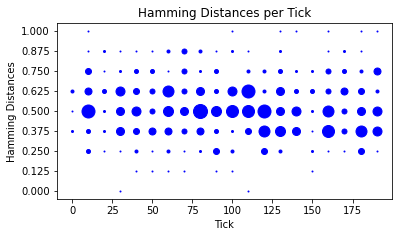

In [5]:
# TODO : representar MELHOR quantas vezes cada valor é repetido
# violin plot?

netlogo.command("setup")
# run go 200 times
netlogo.command("repeat 200 [go]")

# returns an ndarray
report = netlogo.report("compats-report")
print(report)
gen_graph(nd_array_to_compats(report))

# TODO : m / f graphs